In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Chem 277B : HW5 - Statistical Models #

## 1. Baye’s Theorem ##

A chemical test is designed to indirectly determine whether the individual has a 
genetic  marker  predisposing  him/her  to  having  kidney  disease.  The  chemical  test  has  the  following 
characteristics: the probability that a randomly chosen person who has the marker (M) will test positive (i.e. 
"marker present") is: P[+|M] = 0.95; the probability that a randomly chosen person who does not have the 
marker will test negative is: P[-|not M] = 0.95; the proportion of people who have the marker is: P[M] = 
0.01.  

## (a) ##

#### Define the following quantities: P[-|M]; P[+|not M]; P[not M]. ####

P[-|M]: The probability that a person who has the marker (M) will test negative. 

**P[-|M]** = 1 - P[+|M] = 1 - 0.95 = **0.05**

<br>

P[+|not M]: The probability that a person who does not have the market (M) will test positive.

**P[+|not M]** = 1 - P[-|not M] = 1 - 0.95 = **0.05**

<br>

P[not M]: The probability that a person does not have the marker (M)

**P[not M]** = 1 - P[M] = 1 - 0.01 = **0.99**
<br>
<br>

## (b) ## 
**You have had a chemical test and have tested positive; should you be alarmed? To answer this, 
find what is the chance that a randomly selected person who tests positive for the marker actually has the 
marker by using Baye’s Theorem. What feature of the given data accounts for the result?**

$$ P[M|+] = \frac{P[+|M] * P[M]}{P[+]} $$

$$ P[+] = P[+|M] * P[M] + P[+|not M] * P[not M] $$

$$ P[+] = 0.95 * 0.01 + 0.05 * 0.99 = 0.059 $$ 

$$ P[M|+] = 0.95 * 0.01 / 0.059 = 0.161 $$ 


From this we know that the chance that a randomly selected person who tests positive actually has the marker is only 16.1%. Therefore, it is not necessary to be too alarmed from the get-go.

## (c) ##
**Suppose that frequency of marker was higher by a factor of 10, i.e. P[M] = 0.10. What is the 
chance that a randomly selected individual from this group who test positive actually has the marker?**

$$ P[M|+] = \frac{P[+|M] * P[M]}{P[+]} $$

$$ P[+] = P[+|M] * P[M] + P[+|not M] * P[not M] $$

$$ P[+] = 0.95 * 0.10 + 0.05 * 0.90 = 0.14 $$ 

$$ P[M|+] = 0.95 * 0.10 / 0.14 = 0.679 $$ 

If the frequency of the marker was raised to be P[M] = 0.10, the chance that a randomly selected individual who tests positive actually has the marker is 67.9%. 

## 2.  Gaussian Naïve Bayes ##

In a previous homework we clustered 178 wines into 3 cultivars by solving 
the minimization of a cost function simulated annealing. We will do this again, but this time solving it with 
Naïve Bayes. To do this we will classify the wines by assigning them to the cultivar with the largest 
P(cultivar | X), and to find this we must first define a labelled data set of  P(wine attribute x | cultivar) 
pairings to learn the relationship where x is one of the attributes, and do this for all attributes. 

## (a) ##
**How should we represent P(wine attribute x | cultivar) ? Fill in the code for gaussian() function and 
give a reason that you choose this functional form. Given a wine that belongs to cultivar 1, what is the 
chance of it having an Alcohol % of 13 according to the probability distribution function?**

The formula to calculate a Gaussian probability distribution is:
$$ P(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

Therefore, the `gaussian()` function is filled in as below:

In [2]:
def gaussian(x,mean,std):
    return (1/(np.sqrt(2*np.pi)*std))*np.exp(-((x - mean)**2/(2*std**2)))

In [3]:
class NaiveBayesClassifier():
    def __init__(self):
        self.type_indices={}    # store the indices of wines that belong to each cultivar as a boolean array of length 178
        self.type_stats={}      # store the mean and std of each cultivar
        self.ndata = 0
        self.trained=False
    
    @staticmethod
    def gaussian(x,mean,std):
        return (1/(np.sqrt(2*np.pi)*std))*np.exp(-((x - mean)**2/(2*std**2)))
    
    @staticmethod
    def calculate_statistics(x_values):
        # Returns a list with length of input features. Each element is a tuple, with the input feature's average and standard deviation
        n_feats=x_values.shape[1]
        return [(np.average(x_values[:,n]),np.std(x_values[:,n])) for n in range(n_feats)]
    
    @staticmethod
    def calculate_prob(x_input,stats):
        """Calculate the probability that the input features belong to a specific class(P(X|C)), defined by the statistics of features in that class
        x_input: np.array shape(nfeatures)
        stats: list of tuple [(mean1,std1),(means2,std2),...]
        """ 
        init_prob=1
        
        for i in range(len(x_input)):
            init_prob*= NaiveBayesClassifier.gaussian(x_input[i],stats[i][0],stats[i][1])
            
        return init_prob
    
    def fit(self,xs,ys):
        # Train the classifier by calculating the statistics of different features in each class
        self.ndata = len(ys)
        for y in set(ys):
            type_filter= (ys==y)
            self.type_indices[y]=type_filter
            self.type_stats[y]=self.calculate_statistics(xs[type_filter])
        self.trained=True
            
    def predict(self,xs):
        # Do the prediction by outputing the class that has highest probability
        if len(xs.shape)>1:
            print("Only accepts one sample at a time!")
        if self.trained:
            guess=None
            max_prob=0
            # P(C|X) = P(X|C)*P(C) / sum_i(P(X|C_i)*P(C_i)) (deniminator for normalization only, can be ignored)
            for y_type in self.type_stats:
                prob = self.calculate_prob(xs,self.type_stats[y_type]) * np.sum(self.type_indices[y_type])/self.ndata
                if prob>max_prob:
                    max_prob=prob
                    guess=y_type
            return guess
        else:
            print("Please train the classifier first!")

First we need to read in the wine data and obtain the features and the true cultivars and normalize the feature data.

In [4]:
df = pd.read_csv('../Datasets/wines.csv') 
wine_features = df.iloc[:,:13].values 
ranking = df.iloc[:,-1].values  

To calculate the gaussian probability, we need to find the mean and standard deviation of Alcohol % for cultivar 1.

In [5]:
nbc = NaiveBayesClassifier()  
nbc.fit(wine_features, ranking)

alcohol_cultivar1_mean = nbc.type_stats[1][0][0]
alcohol_cultivar1_std = nbc.type_stats[1][0][1]

nbc.gaussian(13., alcohol_cultivar1_mean, alcohol_cultivar1_std)

0.23236757865410362

##### There is a 23.2% chance that a wine that belongs to cultivar 1 has an alcohol percentage of 13%. #####

<br>
<br>

## (b) ##

**Using your normalized chemical descriptor data from HW#2, divide your data into 3-fold training 
and testing groups, i.e. using 2/3 training and 1/3 testing for the three divisions. Does Naïve Baye’s perform 
as well as previous methods?**

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm_wine_features = scaler.fit_transform(wine_features)

nbclassifier = NaiveBayesClassifier()
nbclassifier.fit(norm_wine_features, ranking)

In [7]:
# divide the data into 3-fold training and testing groups
from sklearn.model_selection import train_test_split, KFold

def calculate_accuracy(model,xs,ys):
    y_pred=np.zeros_like(ys)
    for idx,x in enumerate(xs):
        y_pred[idx]=model.predict(x)
    return np.sum(ys==y_pred)/len(ys)

# 3-fold cross validation
kf = KFold(n_splits=3,shuffle=True) 
for train_index, test_index in kf.split(norm_wine_features):
    
    # training data: 2/3, testing data: 1/3
    x_train, x_test = norm_wine_features[train_index], norm_wine_features[test_index]
    y_train, y_test = ranking[train_index], ranking[test_index]

    nbc = NaiveBayesClassifier()
    nbc.fit(x_train,y_train)

    print(f'Accuracy: {calculate_accuracy(nbc,x_test,y_test)}')

Accuracy: 0.9833333333333333
Accuracy: 0.9830508474576272
Accuracy: 0.9661016949152542


Naïve Baye’s performs as well and even better than previous methods. The accuracy of the Naïve Baye's Classifier modifer is approximately within the 0.95-1 range, which is very high. This is much better than the previous method of simulated annealing where approximately 77% of wine cultivars were predicted correctly. 

## 3. Softmax and Cross Entropy Loss ## 

Work on the same wine dataset. Now we use another approach 
to do the classification. Implement a neural network model using PyTorch with no hidden layer (This is 
equivalent to a linear regression plus activation function). Use softmax activation function in the last layer 
and use cross entropy loss as your loss function.   

## (a) ##
**Pass the data through the network once without backpropagation and print out the output. Observe 
the difference between with and without the softmax activation layer. What does softmax do?**

Without softmax activation layer:

In [8]:
# define the model
class NN_no_softmax(nn.Module):
    def __init__(self):
        super(NN_no_softmax,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(13,3),
        )
        
    def forward(self,x):
        return self.layers(x)

In [9]:
wine_no_softmax = NN_no_softmax()

xs_tensor = torch.tensor(norm_wine_features,dtype=torch.float32)
ys_tensor = torch.tensor(ranking,dtype=torch.long)

wine_no_softmax(xs_tensor)

tensor([[-2.9630e-01, -2.5151e-01, -1.1857e-01],
        [-2.5806e-02, -8.3281e-01,  4.8341e-01],
        [-2.1569e-01,  6.2465e-01, -2.2942e-01],
        [-3.1907e-01,  5.3630e-01, -3.4941e-01],
        [-2.5244e-01,  3.3715e-01, -1.9351e-01],
        [-2.8062e-01, -6.7201e-01, -6.4998e-02],
        [-2.3513e-01, -3.2043e-01, -7.7786e-02],
        [-9.3940e-02, -6.5717e-02, -1.4029e-01],
        [ 7.3815e-03, -1.6452e-01, -6.3721e-02],
        [-1.8040e-01,  3.9598e-01, -5.4567e-01],
        [-7.8946e-02,  4.9355e-01, -3.7497e-01],
        [-2.5318e-01, -1.1236e+00, -1.3701e-01],
        [-2.8084e-01, -3.5774e-01,  4.6040e-01],
        [-1.5977e-01,  2.0811e-02,  5.4676e-02],
        [-3.8613e-01, -4.7856e-01, -1.8887e-01],
        [ 1.7506e-01, -2.5003e-01, -3.2874e-01],
        [ 1.5584e-02,  3.5551e-02, -4.0819e-02],
        [-2.7822e-01,  3.4118e-01,  7.8574e-02],
        [-2.9576e-01, -8.3968e-01, -2.4620e-01],
        [-1.9535e-01, -6.8064e-01, -2.9543e-01],
        [ 2.6097e-01

With softmax activation layer:

In [10]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(13,3),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        return self.layers(x)

In [11]:
wine_classifier = NN()
wine_classifier(xs_tensor)

tensor([[0.5494, 0.2907, 0.1599],
        [0.2968, 0.2589, 0.4443],
        [0.5351, 0.2852, 0.1797],
        [0.5000, 0.2395, 0.2605],
        [0.4888, 0.2595, 0.2518],
        [0.4450, 0.2951, 0.2599],
        [0.6023, 0.2345, 0.1632],
        [0.4834, 0.1942, 0.3224],
        [0.5262, 0.1921, 0.2817],
        [0.4760, 0.2133, 0.3107],
        [0.5931, 0.2300, 0.1768],
        [0.3292, 0.2321, 0.4387],
        [0.2694, 0.2579, 0.4726],
        [0.3781, 0.2205, 0.4014],
        [0.5564, 0.2353, 0.2083],
        [0.5928, 0.2425, 0.1647],
        [0.5241, 0.2998, 0.1761],
        [0.5676, 0.2470, 0.1854],
        [0.5426, 0.2562, 0.2012],
        [0.6161, 0.2384, 0.1455],
        [0.1128, 0.1596, 0.7275],
        [0.7042, 0.1172, 0.1786],
        [0.7355, 0.1782, 0.0863],
        [0.2695, 0.3005, 0.4300],
        [0.1389, 0.2002, 0.6608],
        [0.4183, 0.1480, 0.4337],
        [0.5165, 0.2836, 0.1999],
        [0.4828, 0.1775, 0.3397],
        [0.2679, 0.2267, 0.5054],
        [0.501

Softmax turns the original output from the linear regression into a probability distribution so that all of the values are between 0 and 1 and the sum of the probabilities for each sample adds up to 1.
<br>
<br>

## (b) ##

**Divide  your  data  into  3-fold  training  and  testing  groups,  within  each  fold  further  divide  your 
training data into 80% training and 20% validation, choose the model for the epoch with lowest validation 
error. Report error in terms of success rate of classification. How well is the prediction?**

In [12]:
def train_and_val(model,Xs,ys,epochs,draw_curve=True):
    """
    Parameters
    --------------
    model: a PyTorch model
    train_X: np.array shape(ndata,nfeatures)
    train_y: np.array shape(ndata)
    epochs: int
    draw_curve: bool
    """
    ### Define your loss function, optimizer. Convert data to torch tensor ###
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    Xs = torch.tensor(Xs, dtype=torch.float32)
    ys = torch.tensor(ys, dtype=torch.long)
    
    # Kfolds 
    kf = KFold(n_splits=3,shuffle=True)
    for train_index, test_index in kf.split(Xs):
        train_Xs=Xs[train_index]
        train_ys=ys[train_index]
        test_Xs=Xs[test_index]
        test_ys=ys[test_index]

        val_array=[]
        best_weights = {}
        lowest_val_loss = np.inf

        # Split training examples further into training and validation
        train_in, val_in, train_real, val_real = train_test_split(train_Xs, train_ys, test_size=0.2)
        for i in range(epochs):
            
            # Compute prediction error
            pred = model(train_in)
            loss_train = loss(pred, train_real)

            # Backpropagation
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            ### compute validation loss and keep track of the lowest val loss ###
            val_pred = model(val_in)
            val_err = loss(val_pred, val_real)
            val_array.append(val_err.item())
            if val_err.item() < lowest_val_loss:
                lowest_val_loss = val_err.item()
                best_weights = model.state_dict()
                
     # The final number of epochs is when the minimum error in validation set occurs    
    final_epochs=np.argmin(val_array)+1
    print("Number of epochs with lowest validation:",final_epochs)
    ### Recover the model weight ###
    model.load_state_dict(best_weights)

    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

Number of epochs with lowest validation: 1000


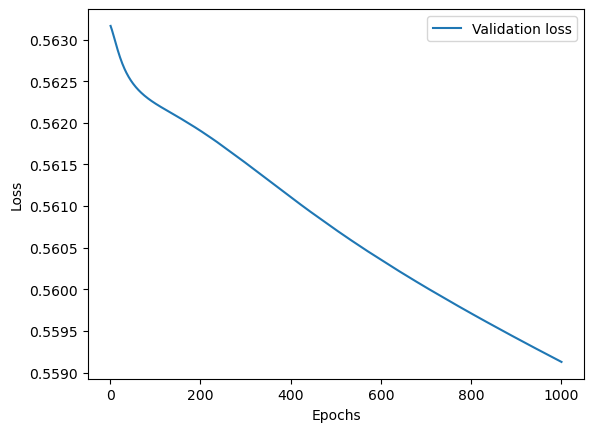

In [13]:
adjusted_ranking = ranking - 1 #(1,2,3) to (0,1,2)
train_and_val(wine_classifier, norm_wine_features, adjusted_ranking, 1000)

The prediction is not super great because even after several epochs, the loss does not decrease below approximately 0.5590

In [14]:
def calculate_accuracy(model,xs,ys):
    print(ys.size())
    y_pred = model(xs)
    y_pred = y_pred.detach().numpy()
    y_pred = np.argmax(y_pred,axis=1)
    ys = ys.detach().numpy()
    return np.sum(ys==y_pred)/len(ys)

In [15]:
calculate_accuracy(wine_classifier, xs_tensor, ys_tensor)

torch.Size([178])


0.011235955056179775

The success rate of classification is really low at 1.1%.